<a href="https://colab.research.google.com/github/B4Farouk/smpl-dr-clip/blob/main/simpledCLIP3_Albin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependencies


### torch, torchvision

In [ ]:
# install torch and torchvision
!pip3 install torch torchvision torchaudio torchtext --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


### pytorch3d

In [ ]:
import os
import torch

need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
import pytorch3d
pytorch3d.__version__

'0.7.1'

### SMPL / Meshes

In [ ]:
!pip install smplpytorch
!pip install chumpy
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### CLIP

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-pqjhc66m
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-pqjhc66m


## GPU

In [ ]:
import torch

torch.cuda.is_available()

True

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [ ]:
# GPU or CPU
gpu, cpu = None, None
if torch.cuda.is_available():
    gpu = torch.device("cuda:0")
    torch.cuda.set_device(gpu)
else:
    cpu = torch.device("cpu")
dev = gpu if gpu is not None else cpu
dev

device(type='cuda', index=0)

## Setup

### Codebase Loading

In [ ]:
!rm -rf project #remove if it already exists 
!git clone https://github.com/B4Farouk/smpl-dr-clip project
!rm -rf sample_data

Cloning into 'project'...
remote: Enumerating objects: 755, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 755 (delta 73), reused 75 (delta 34), pack-reused 622
Receiving objects: 100% (755/755), 70.30 MiB | 17.05 MiB/s, done.
Resolving deltas: 100% (441/441), done.
Checking out files: 100% (27/27), done.


### Local Imports 

In [ ]:
from project.aux_functions import *

from project.smpl import SMPLwrapper, mesh_from
from project.textures import TexturesFactory
from project.rendering import CamerasFactory, Renderer
from project.clipwrapper import CLIPwrapper

from project.optimization import OptimEnv, init_weights
from project.model import compose, SimpledCLIPContext

import trimesh

import clip

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test: SMPL and Rendering

In [ ]:
# initalize a textures factory
txfactory = TexturesFactory(device=dev)
colored_reference_SMPL = trimesh.load("project/SMPL_female_with_colors.obj", process=False)
# use the texture factory to create a texture generator: a function that takes faces and creates a texture
def texture_generator(verts,faces):
  return txfactory.from_image(colored_reference_SMPL ,verts, faces)
# pose and shape initalization
pose_vect = torch.zeros((1, 72), device=dev) # theta, used in optimization
shape_vect = torch.ones((1, 10), device=dev) # beta, not used in optimization
# create the smpl model
smpl_model = SMPLwrapper(model=None, batchsize=5, txmapping=texture_generator, device=dev) #model=None uses the default model
# create the mesh
meshes = smpl_model.meshes(theta=pose_vect, beta=shape_vect)

In [ ]:
# create a cameras factory
camsfactory = CamerasFactory(device=dev)
# cameras' spherical coordinates
radiuses = [2]*5
azimuths = (0, 45, 135, -45, -135)
elevations = [10]*5
coords = (radiuses, azimuths, elevations)
# create cameras using cameras factory
cameras = camsfactory.fov_persp_scs(coords=coords, fov=60, frustrum_depth=(1, 100))
# create a renderer
renderer = Renderer(device=dev, cameras=cameras)
# render the textured meshes generated by SMPL
test_imgs_t = renderer.render(meshes)
# shape of the rendered images
test_imgs_t.shape

torch.Size([5, 244, 244, 4])

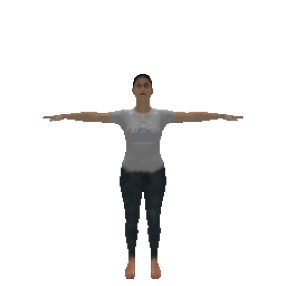

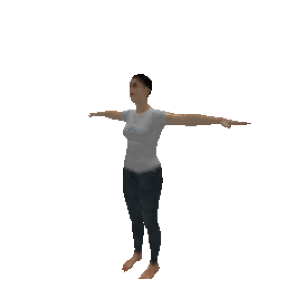

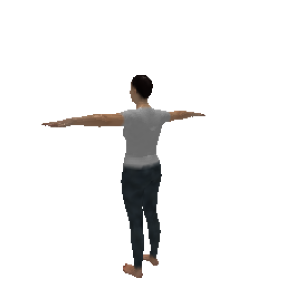

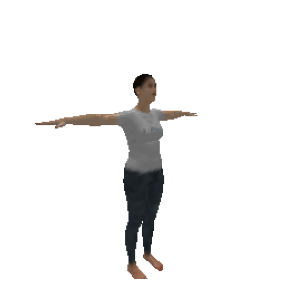

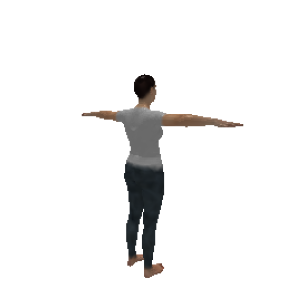

In [ ]:
# a quick visualization of the rendered mesh
for test_img_t in test_imgs_t:
  plot_image_t(test_img_t)

## Test: CLIP

In [ ]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
clip_model = CLIPwrapper(model_name="ViT-B/32", device=dev)

#### Test: Our Implementation of CLIP Image Preprocessing

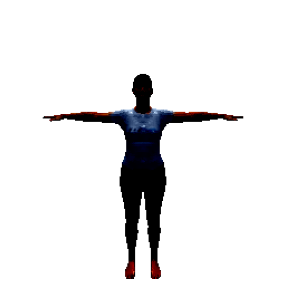

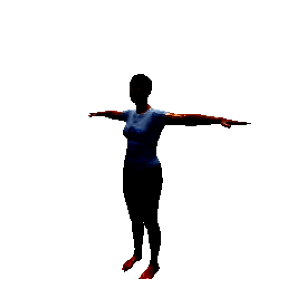

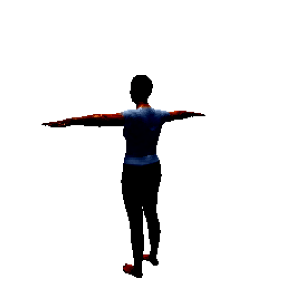

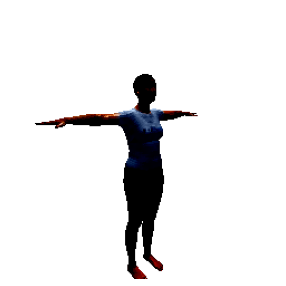

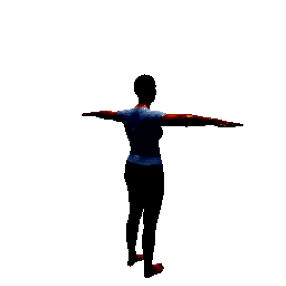

In [ ]:
proc_test_imgs_t = torch.permute(clip_model.proc_imgs(test_imgs_t), (0, 2, 3, 1)) # N 3 W H => N W H 3 so 0 1 2 3 => 0 2 3 1
# a quick visualization of the processed images (matplotlib automatically clamps the pixels)
for proc_test_img_t in proc_test_imgs_t:
  plot_image_t(proc_test_img_t)

#### Test: How much does CLIP recognize our mesh and the position it is in ?

In [ ]:
# a prompt describing the previous image
pmt_emb = clip_model.pmt_emb("""a white human wearing a light grey T-shirt and blue pants, standing up on her straight feet. She is looking upfront with both hands apart and at the shoulder level.""")
imgs_embs = clip_model.imgs_embs(test_imgs_t)

In [ ]:
imgs_embs.shape, pmt_emb.shape

(torch.Size([5, 512]), torch.Size([1, 512]))

In [ ]:
img_emb = imgs_embs.mean(axis=0, keepdims=True)
float(cos_dist(img_emb, pmt_emb))

0.728515625

In [ ]:
cosine_distances = torch.Tensor([cos_dist(img_emb.unsqueeze(0), pmt_emb) for img_emb in imgs_embs])
cosine_distances

tensor([0.7207, 0.7080, 0.7598, 0.7285, 0.7500])

In [ ]:
float(cosine_distances.mean())

0.7333984375

## MODELS


In [ ]:
# create a model factory
model_context = SimpledCLIPContext(smpl_model, renderer, clip_model) 
MODELS = {
    "P1": model_context.create(
        prompt="""A person with their hands down.""")
    }

### Test: Does the model work ?

In [ ]:
pose, shape = init_weights(dev)
test_imgs_embs, test_pmt_emb = MODELS["P1"](pose, shape)
test_imgs_embs.shape, test_pmt_emb.shape

(torch.Size([5, 512]), torch.Size([1, 512]))

### Optimization

In [ ]:
# optimization config
optim_config = {
    "lr": 1e-3,
    "betas": (0.9, 0.999),

    "loss_mode": "average-loss-on-embeddings",
    'sch_min_lr':1e-3,
    "sch_factor": 0.5,
    "sch_patience": 5,
    "sch_threshold": 1e-2,
    "sch_cooldown": 50,
    "sch_verbose": True
}

# tracker config
tracker_config = {
    "loss": {"interleaving": 10}, 
    "pose": {"interleaving": 100},
    "shape": {"interleaving": 100}
}


def run_optimization(model, n_passes=1000, activate_lr_sch=False):
  # weights used in optimization
  pose, shape = init_weights(device=dev) 
  # optimize with respect to the pose only
  optimenv = OptimEnv(model=model, weights=[pose], activate_lr_sch=activate_lr_sch, config=optim_config) 
  result = optimenv.optimize(pose=pose, shape=shape, n_passes=n_passes, tracker_config=tracker_config)
  return result

def intermediate_views(result, coords):
  smpl_model = SMPLwrapper(model=None, batchsize=1, txmapping=texture_generator, device=dev) #model=None uses the default model
  camera = camsfactory.fov_persp_scs(coords=coords, fov=60, frustrum_depth=(1, 100))
  renderer = Renderer(cameras=camera, device=dev)
  
  pose_shape = zip(result["tracked"]["poses"]["pose"], result["tracked"]["shapes"]["shape"])
  for pose, shape in pose_shape:
    pose, shape = pose.to(dev), shape.to(dev)
    mesh = smpl_model.meshes(theta=pose, beta=shape)
    image = renderer.render(mesh)
    plot_image_t(image.squeeze())

### Results

In [ ]:
p1_result = run_optimization(model=MODELS["P1"], n_passes=1000, activate_lr_sch=False)

number of passes is: 1000
number of passes is: 1000
number of passes is: 1000
number of passes is: 1000
number of passes is: 1000
number of passes is: 1000
number of passes is: 1000
number of passes is: 1000
number of passes is: 1000
number of passes is: 1000


(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2c1f8d4160>)

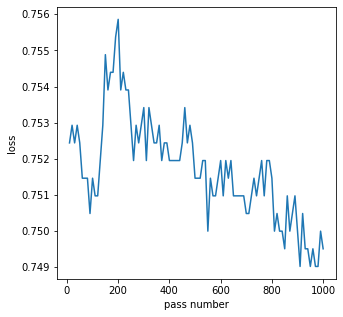

In [ ]:
plot_losses(p1_result["tracked"]["losses"])

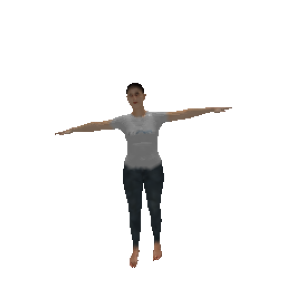

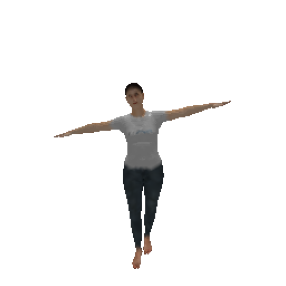

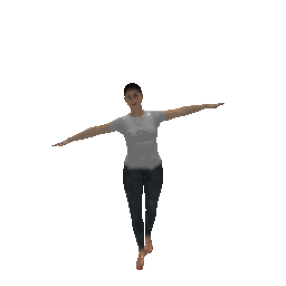

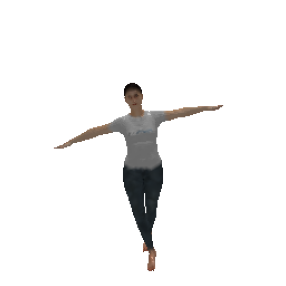

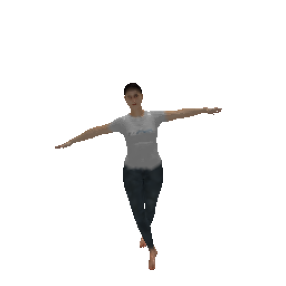

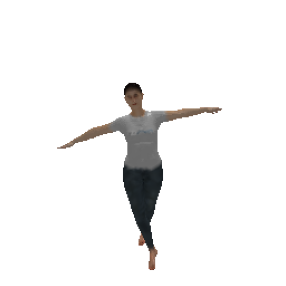

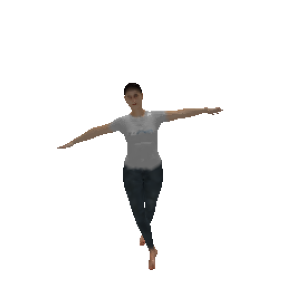

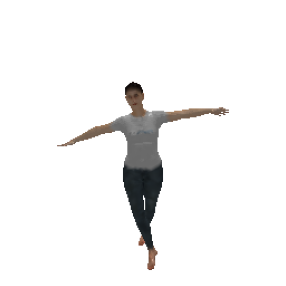

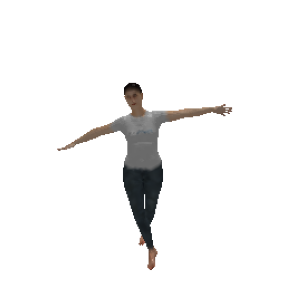

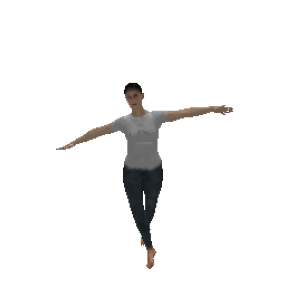

In [ ]:
intermediate_views(p1_result, coords=(2.25, 0, 10))

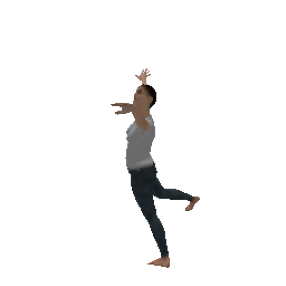

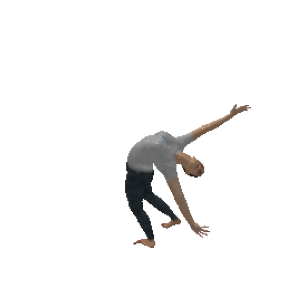

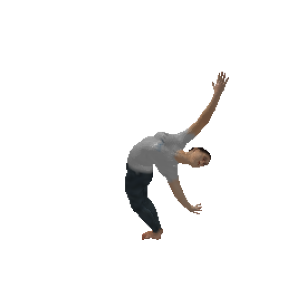

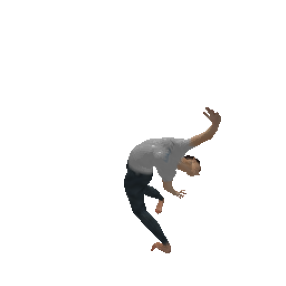

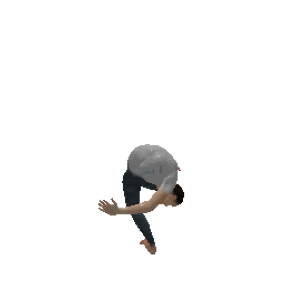

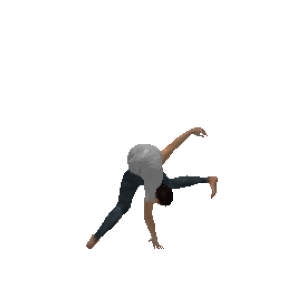

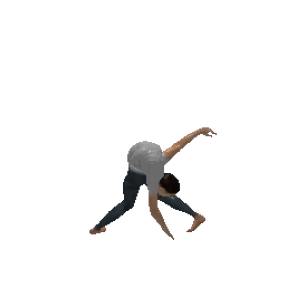

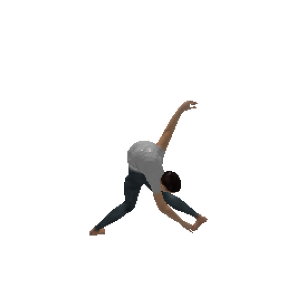

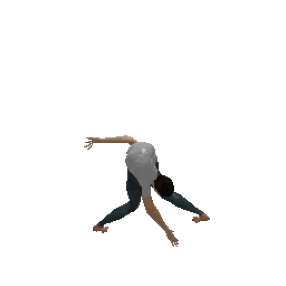

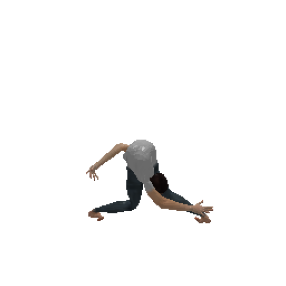

In [ ]:
intermediate_views(p1_result, coords=(2.25, 90, 10))

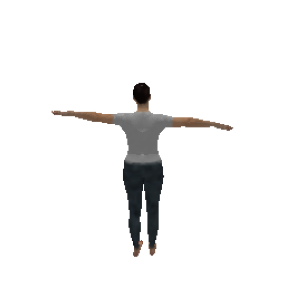

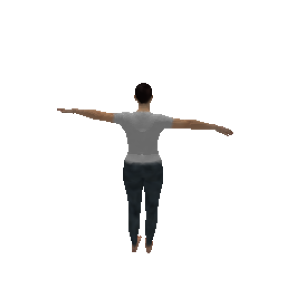

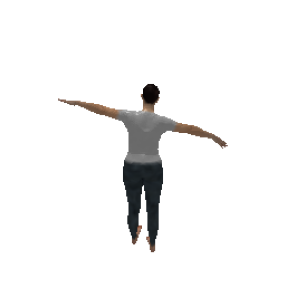

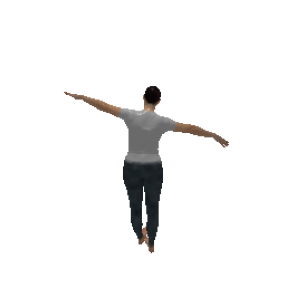

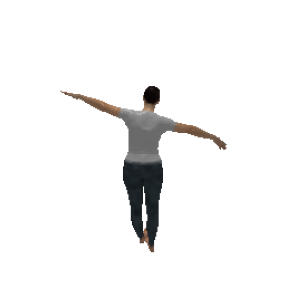

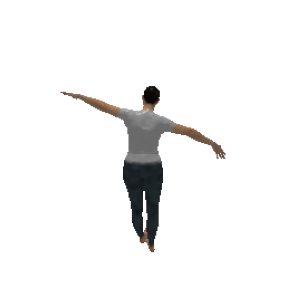

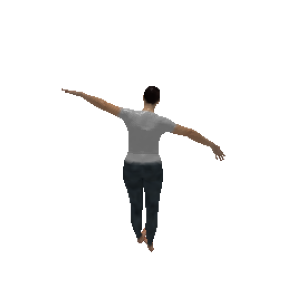

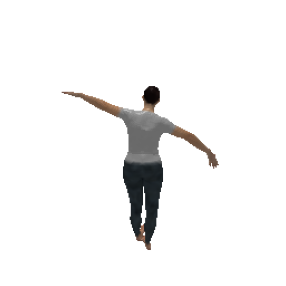

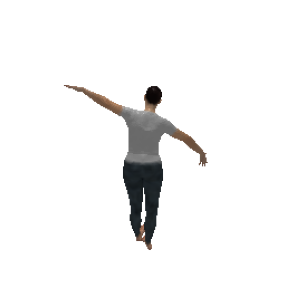

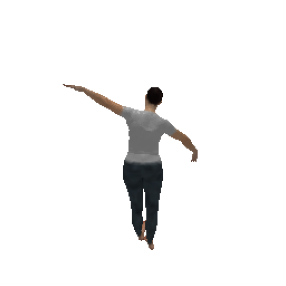

In [ ]:
intermediate_views(p1_result, coords=(2.25, 180, 10))

In [ ]:
p1_LRsch_result = run_optimization(MODELS["P1"], n_passes=1000, activate_lr_sch=True)

Epoch 00007: reducing learning rate of group 0 to 5.0000e-02.
Epoch 00063: reducing learning rate of group 0 to 2.5000e-02.
number of passes is: 1000
Epoch 00119: reducing learning rate of group 0 to 1.2500e-02.
Epoch 00175: reducing learning rate of group 0 to 6.2500e-03.
number of passes is: 1000
Epoch 00231: reducing learning rate of group 0 to 3.1250e-03.
Epoch 00287: reducing learning rate of group 0 to 1.5625e-03.
number of passes is: 1000
Epoch 00343: reducing learning rate of group 0 to 7.8125e-04.
Epoch 00399: reducing learning rate of group 0 to 3.9063e-04.
number of passes is: 1000
Epoch 00455: reducing learning rate of group 0 to 1.9531e-04.
number of passes is: 1000
Epoch 00511: reducing learning rate of group 0 to 9.7656e-05.
Epoch 00567: reducing learning rate of group 0 to 5.0000e-05.
number of passes is: 1000
number of passes is: 1000
number of passes is: 1000
number of passes is: 1000
number of passes is: 1000


In [ ]:
plot_losses(result2["tracked"]["losses"])

NameError: ignored

In [ ]:
intermediate_views(result2, coords=(2.25, 0, 3))